In [3]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from tqdm import tqdm
import sqlite3 as sl
import os

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pathlib
from os.path import join
import shutil


def retrieve_relevant_file_paths(
        experiment_folder: str, 
        program_id: str,
        root_folder: str = "../data"):
    """Create the file paths."""
    main_path = os.path.join(root_folder, experiment_folder, "programs")
    path_dict = {
        "source": join(main_path, "source", f"{program_id}.py"),
        "followup": join(main_path, "followup", f"{program_id}.py"),
        "metadata": join(main_path, "metadata", f"{program_id}.json"),
        "metadata_exec": join(main_path, "metadata_exec", f"{program_id}.json")
    }
    return path_dict
    
def create_folder_in_interesting_cases(
        experiment_folder: str, 
        program_id: str,
        root_folder: str = "../intersting_cases/metamorphic_testing"):
    """Create destination folder for the relevant files."""
    number = "".join([c for c in experiment_folder if c.isdigit()])
    new_folder_name = f"{number}_{program_id[:6]}"
    new_folder_path = os.path.join(root_folder, new_folder_name)
    pathlib.Path(new_folder_path).mkdir(parents=True, exist_ok=True)
    return new_folder_path


def copy_bug(
        experiment_folder: str, 
        program_id: str, 
        root_data_folder: str = "../data",
        root_bug_folder: str = "../intersting_cases/metamorphic_testing"):
    """Copy all the files of the interesting bug."""
    dest_folder = create_folder_in_interesting_cases(
        experiment_folder=experiment_folder,
        program_id=program_id,
        root_folder=root_bug_folder
    )
    
    original_file_paths = retrieve_relevant_file_paths(
        experiment_folder=experiment_folder,
        program_id=program_id,
        root_folder=root_data_folder    
    )
    
    for k, original_file_path in original_file_paths.items():
        basename = os.path.basename(original_file_path)
        dest_file_path = join(dest_folder, f"{k}_{basename}")
        print(f"Copying... from {original_file_path} to {dest_file_path}")
        shutil.copy(original_file_path, dest_file_path)

## Scan the exception via SQL

In [55]:
import pandas as pd

EXP_FOLDER = "qmt_v06" 
sql_path = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
con = sl.connect(sql_path)
df = pd.read_sql("""SELECT * from QFLDATA""", con)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            2519 non-null   int64  
 1   program_id                       2519 non-null   object 
 2   source.program_id                2519 non-null   object 
 3   source.selected_gate_set         2519 non-null   object 
 4   source.selected_optimization     2519 non-null   object 
 5   source.shots                     2519 non-null   int64  
 6   source.n_qubits                  2519 non-null   int64  
 7   source.n_ops                     2519 non-null   int64  
 8   source.opt_level                 2519 non-null   int64  
 9   source.target_gates              0 non-null      object 
 10  source.py_file_path              2519 non-null   object 
 11  source.circuit_id                2519 non-null   object 
 12  source.id_quantum_re

In [62]:
from collections import Counter
c = Counter(df["exceptions.followup"])
c.most_common(10)

[(None, 1447),
 ("'qargs not in this circuit'", 997),
 ('too many subscripts in einsum', 15),
 ('"Cannot unroll the circuit to the given basis, [\'cx\', \'h\', \'s\', \'t\']. Instruction id not found in equivalence library and no rule found to expand."',
  8),
 ('"Cannot unroll the circuit to the given basis, [\'rx\', \'ry\', \'rz\', \'p\', \'cx\']. Instruction id not found in equivalence library and no rule found to expand."',
  6),
 ('"Unable to map source basis {(\'p\', 1), (\'rzz\', 2), (\'cu\', 2)} to target basis {\'h\', \'delay\', \'reset\', \'ccx\', \'barrier\', \'measure\', \'snapshot\'} over library <qiskit.circuit.equivalence.EquivalenceLibrary object at 0x7f4c653634c0>."',
  4),
 ('"Unable to map source basis {(\'u1\', 1), (\'u3\', 1), (\'p\', 1), (\'u2\', 1), (\'dcx\', 2), (\'swap\', 2), (\'rzz\', 2), (\'cu\', 2), (\'cx\', 2)} to target basis {\'h\', \'cx\', \'delay\', \'reset\', \'t\', \'barrier\', \'s\', \'measure\', \'snapshot\'} over library <qiskit.circuit.equivalence

In [65]:
df_specific_class = df[df["exceptions.followup"] == "too many subscripts in einsum"]
print(df_specific_class.shape)
df_specific_class.iloc[0]["program_id"]

(15, 33)


'948f90de9947418289b220bd2e61caa3'

## Scan the log for interesting cases

In [39]:
EXP_FOLDER = "qmt_v05" 
log_path = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
log_content = open(log_path, 'r').read()
log_lines = log_content.split("\n")

In [44]:
len(log_lines)

412987149

In [49]:
from typing import List
from numba import njit

@njit
def scan_log_for(log_lines: List[str], 
                 target_string: str,
                 exclude_string: str, 
                 neighborhood: int = 3):
    """Returns all the lines with the target string."""
    relevant_lines: List[List[str]] = []
    i: int = 0
    for line in log_lines:
        if target_string in line and exclude_string not in line: 
            relevant_lines.append(log_lines[i-neighborhood : i+neighborhood])
        i = i + 1
    return relevant_lines
    

In [52]:
import numba as nb
numba_log_lines = nb.typed.List(log_lines)

KeyboardInterrupt: 

### Clear crashes

In [50]:
relevant_lines = scan_log_for(
    log_lines=log_lines[:10], 
    target_string="'followup':",
    exclude_string="'followup': None"
)
relevant_lines

/home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'log_lines' of function 'scan_log_for'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_9907/1720171298.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[]

### Divergent Cases

In [19]:

relevant_lines = scan_log_for(log_lines=log_lines, target_string="divergent")

In [20]:
relevant_lines

[['(i: 1) current p-value: 7.194161635831281e-05 vs threshold: 0.00019920318725099602',
  '(i: 2) current p-value: 0.0005683635386320926 vs threshold: 0.00039840637450199205',
  'i*: 1',
  '1 new divergent programs found.',
  '     index                        program_id                 source.program_id  ... divergence.ks.p-value exceptions.source  exceptions.followup',
  '250      0  1138a36bc2314a709c00dc4b4cf81546  1138a36bc2314a709c00dc4b4cf81546  ...              0.000072              None                 None'],
 ['(i: 2) current p-value: 7.194161635831281e-05 vs threshold: 0.0002100840336134454',
  '(i: 3) current p-value: 0.0005683635386320926 vs threshold: 0.0003151260504201681',
  'i*: 2',
  '1 new divergent programs found.',
  '     index                        program_id                 source.program_id  ... divergence.ks.p-value exceptions.source  exceptions.followup',
  '475      0  84bfec144af64578911f7b1717ceaa12  84bfec144af64578911f7b1717ceaa12  ...               0.

In [10]:
# qmt_v04 22 Feb 2022 - 21.00
# 55385058d848436999d31be9c0d45387  4.561414e-07 
# 700ae3ec79e747d48df6d0c3a295bf7f  4.640498e-07
# 9fd329b62a4d4f76a82bef40a43e3c41  9.427501e-07
# bf9d01db885a4c65a8e28e5ff4e06ef9  7.748918e-07 
# 9044f1ee448d4f79999afe768e5e7b3f  2.906607e-07
# 4dbd77852fc84c41a515e84a7b0ef8b5  7.049732e-09
# 8ae5d6abf9ee4bb8813aab605e5e036d  8.337349e-07
# 83936da814534c7ba7275030fa389b45  6.009361e-07

In [9]:
log_lines[:20]

['Starting loop... [no timer]',
 'New program couple... [timer: 120 sec]',
 'Executing: f53cc98f2591430887207c1d0bad0ce3',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.21832550182998656 vs threshold: 0.05',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: f3773a633a664e02810b372d000f0937',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.06382648295290216 vs threshold: 0.025',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: 87bd57221135466aa5fbe6d64823225c',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.02698591735714151 vs threshold: 0.016666666666666666',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: 2c78a8718f664594975911795686b986',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.02698591735714151 vs threshold: 0.0125']

## Copy in Intesting Cases

In [66]:
# copy a given program in the interesting cases folder
EXP_FOLDER = "qmt_v06" 
PROGRAM_ID = "948f90de9947418289b220bd2e61caa3"

In [67]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v06/programs/source/948f90de9947418289b220bd2e61caa3.py',
 'followup': '../data/qmt_v06/programs/followup/948f90de9947418289b220bd2e61caa3.py',
 'metadata': '../data/qmt_v06/programs/metadata/948f90de9947418289b220bd2e61caa3.json',
 'metadata_exec': '../data/qmt_v06/programs/metadata_exec/948f90de9947418289b220bd2e61caa3.json'}

In [68]:
create_folder_in_interesting_cases(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)

'../intersting_cases/metamorphic_testing/06_948f90'

In [69]:
copy_bug(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)

Copying... from ../data/qmt_v06/programs/source/948f90de9947418289b220bd2e61caa3.py to ../intersting_cases/metamorphic_testing/06_948f90/source_948f90de9947418289b220bd2e61caa3.py
Copying... from ../data/qmt_v06/programs/followup/948f90de9947418289b220bd2e61caa3.py to ../intersting_cases/metamorphic_testing/06_948f90/followup_948f90de9947418289b220bd2e61caa3.py
Copying... from ../data/qmt_v06/programs/metadata/948f90de9947418289b220bd2e61caa3.json to ../intersting_cases/metamorphic_testing/06_948f90/metadata_948f90de9947418289b220bd2e61caa3.json
Copying... from ../data/qmt_v06/programs/metadata_exec/948f90de9947418289b220bd2e61caa3.json to ../intersting_cases/metamorphic_testing/06_948f90/metadata_exec_948f90de9947418289b220bd2e61caa3.json


## Rerun programs

In [70]:
from qmt import execute_programs
from detectors import KS_Detector
from inspector import OneNightStandInspector

In [71]:
RES = execute_programs(
    metadata_source = {"py_file_path": BUG_PATHS["source"]},
    metadata_followup = {"py_file_path": BUG_PATHS["followup"]}
)
RES

Crash found. Exception:  {'source': None, 'followup': 'too many subscripts in einsum'}


{'res_A': {'00001000010': 1,
  '00001010100': 13,
  '10000000000': 6,
  '00000010100': 82,
  '00000010110': 659,
  '00000000010': 8,
  '10000000010': 49,
  '10001000010': 4,
  '10001010110': 746,
  '10001010100': 86,
  '10000010100': 676,
  '00001010110': 88,
  '10000010110': 5420},
 'platform_A': 'source',
 'res_B': {'0': 1},
 'platform_B': 'follow_up',
 'exceptions': {'source': None, 'followup': 'too many subscripts in einsum'}}

In [34]:
detector = KS_Detector()
detector.check(RES["res_A"], RES["res_B"])

(0.003827507017096221, 0.9998218674014483)

n_qubits: 11
n_shots_platform_a: 7838.0
n_shots_platform_b: 61434244.0
Uniform threshold: 0.00048828125


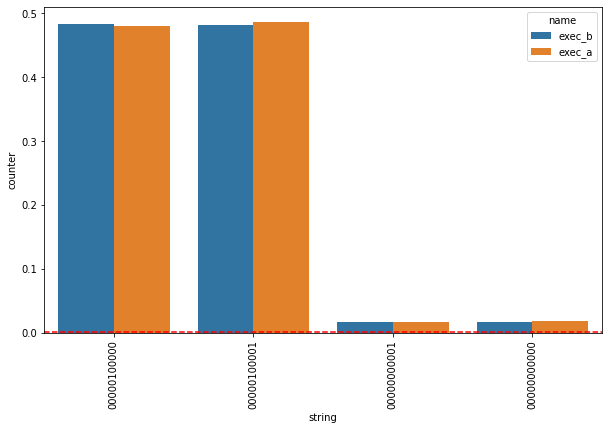

In [36]:
OneNightStandInspector(RES["res_A"], RES["res_B"], top_perc=.25)

## BUG: too many subscripts in einsum
qmt_v06 948f90de9947418289b220bd2e61caa3

In [34]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.x(3)
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.x(3)
qc.draw(fold=-1)

┌──────────────┐     
 qr_0: ┤0             ├─────
       │              │     
 qr_1: ┤1             ├─────
       │              │     
 qr_2: ┤2             ├─────
       │              │┌───┐
 qr_3: ┤3             ├┤ X ├
       │              │└───┘
 qr_4: ┤4             ├─────
       │              │     
 qr_5: ┤5             ├─────
       │              │     
 qr_6: ┤6             ├─────
       │              │     
 qr_7: ┤7             ├─────
       │              │     
 qr_8: ┤8             ├─────
       │              │     
 qr_9: ┤9             ├─────
       │              │     
qr_10: ┤10            ├─────
       │   subcircuit │     
 cr_0: ╡0             ╞═════
       │              │     
 cr_1: ╡1             ╞═════
       │              │     
 cr_2: ╡2             ╞═════
       │              │     
 cr_3: ╡3             ╞═════
       │              │     
 cr_4: ╡4             ╞═════
       │              │     
 cr_5: ╡5             ╞═════
       │              │     
 cr_6: ╡6             ╞═════
       │              │     
 cr_7: ╡7             ╞═════
       │              │     
 cr_8: ╡8             ╞═════
       │              │     
 cr_9: ╡9             ╞═════
       │              │     
cr_10: ╡10            ╞═════
       └──────────────┘

In [37]:
import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

--Return--
None
> /tmp/ipykernel_41006/1682671566.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 21 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
21-> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                         pass

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-p

ipdb> q


BdbQuit: 

In [16]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
# fails when (8 continue then 1 step)
# print(current_gate.op); print(prev_gate.op); end
# Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
# Instruction(name='subcircuit_dg', num_qubits=11, num_clbits=11, params=[])


# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:137
# genexpr # qarg1 = tuple(qarg[q] for q in node1.qargs)

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py:451
# _einsum_matmul()

In [14]:
# 11 bits failing
import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)


--Return--
None
> /tmp/ipykernel_41006/2811827985.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 10 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> commands 10 
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
10-> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                   

ipdb> commands 5 
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
3--> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                         pass

ipdb> print(current_gate.op); print(prev_gate.op);
Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
Instruction(name='subcircuit', num_qubits=11, num_clbits=11, params=[])
ipdb> s
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(117)_commute()
    115 
    116 
--> 117 def _commute(node1, node2, cache):
    118     if not isinstance(node1, DAGOpNode) or not isinstance(node2, DAGOpNode):

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(244)compose()
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
    243         input_dims = new_shape.dims_r()
--> 244         output_dims = new_shape.dims_l()
    245 
    246         # Full composition of operators

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(247)compose()
    245 
    246         # Full composition of operators
--> 247         if qargs is None:
    248             if front:
    249                 # Composition self * other

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(259)compose()
    257 
    258         # Compose with other on subsystem
--> 259         num_qargs_l, num_qargs_r = self._op_shape.num_qargs
    260         if front:
    261             num_indices = num_qar

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(276)compose()
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
--> 276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(277)compose()
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
--> 277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape
    279         )

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ipdb> tensor.shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> final_shape[0]
2048
ipdb> indices
[9, 8, 7, 10, 6, 5, 4, 3, 2, 1, 0]
ipdb> qargs
(1, 2, 3, 0, 4, 5, 6, 7, 8, 9, 10)
ipdb> self._op_shape.tensor_shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> right_mul.shape
*** AttributeError: 'bool' object has no attribute 'shape'
ipdb> right_mul
False
ipdb> shift
0
ipdb> mat.shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> mat.ndim
22
ipdb> tensor.ndim
22
ipdb> n
ValueError: too many subscripts in einsum
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(278)compose()
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
--> 278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape
    279         )
    280         ret = Operator(data, input_dims,

BdbQuit: 

In [11]:
# 10 bits WORKING

import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)


--Return--
None
> /tmp/ipykernel_41006/2811827985.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 8 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> commands
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
8--> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                        

ipdb> print(current_gate.op); print(prev_gate.op);
Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
Instruction(name='subcircuit', num_qubits=10, num_clbits=10, params=[])
ipdb> s
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(117)_commute()
    115 
    116 
--> 117 def _commute(node1, node2, cache):
    118     if not isinstance(node1, DAGOpNode) or not isinstance(node2, DAGOpNode):
    119         return False

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170
Breakpoint 9 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(170)_commute()
    168            

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(243)compose()
    241         # operator dimensions
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
--> 243         input_dims = new_shape.dims_r()
    244         output_dims = new_shape.dims_l()
    245 

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(244)compose()
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
    243         input_dims = new_shape.dims_r()
--> 244         output_dims = new_shape.dims_l()
    245 
    246         # Full composition of operators

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(247)compose()
    245 
    246         # Full composition of operators
--> 247         if qargs is None:
    248             if front:
    249            

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(275)compose()
    273         tensor = np.reshape(self.data, self._op_shape.tensor_shape)
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
--> 275         indices = [num_indices - 1 - qubit for qubit in qargs]
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(276)compose()
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
--> 276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape

ipdb> list 276
    271         # qubit 

BdbQuit: 

In [96]:
qr = QuantumRegister(1, name='qr')
cr = ClassicalRegister(1, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(XGate(), qargs=[qr[0]], cargs=[])
qc.append(XGate(), qargs=[qrc[0]], cargs=[])
qc.append(PhaseGate(1.4169402094934866), qargs=[qr[0]], cargs=[])
qc.draw(fold=-1)

┌───┐┌───┐┌───────────┐
  qr: ┤ X ├┤ X ├┤ P(1.4169) ├
      └───┘└───┘└───────────┘
cr: 1/═══════════════════════

In [107]:
%debug

> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/numpy/core/einsumfunc.py(1361)einsum()
   1359         if specified_out:
   1360             kwargs['out'] = out
-> 1361         return c_einsum(*operands, **kwargs)
   1362 
   1363     # Check the kwargs to avoid a more cryptic error later, without having to

ipdb> q
